In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drowsiness-dataset/train/Closed/_225.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_419.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_269.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_86.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_707.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_163.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_19.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_194.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_652.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_580.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_330.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_212.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_500.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_454.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_498.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_458.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_106.jpg
/kaggle/input/drowsiness-dataset/train/Closed/_335.jpg
/kaggle/inpu

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets  # Import datasets module from torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
# 1. Prepare the dataset and split into train and test sets
data_root = "/kaggle/input/drowsiness-dataset/train"  

# Define the transformation applied to the images
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset using torchvision.datasets.ImageFolder
dataset = datasets.ImageFolder(root=data_root, transform=transform)

# Split the dataset into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders for train and test sets
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [ ]:
# 2. Define the AlexNet model for drowsiness detection
class AlexNet(nn.Module):
    def __init__(self, num_classes=4):  # `num_classes` is set to 4 for ['Folder1', 'Folder2', 'Folder3', 'Folder4'] classes
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # Convolution Layer 1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # Max Pooling Layer 1
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # Convolution Layer 2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # Max Pooling Layer 2
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # Convolution Layer 3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # Convolution Layer 4
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Convolution Layer 5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # Max Pooling Layer 3
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),  # Fully connected Layer 1
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),  # Fully connected Layer 2
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # Output Layer
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [18]:
# 3. Define the loss function and optimizer
model = AlexNet(num_classes=4)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# 4. Training loop
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch [1/10] - Loss: 1.1039, Accuracy: 46.47%
Epoch [2/10] - Loss: 0.6250, Accuracy: 65.00%
Epoch [3/10] - Loss: 0.4320, Accuracy: 76.64%
Epoch [4/10] - Loss: 0.5016, Accuracy: 73.36%
Epoch [5/10] - Loss: 0.4073, Accuracy: 76.81%
Epoch [6/10] - Loss: 0.4071, Accuracy: 78.49%
Epoch [7/10] - Loss: 0.3528, Accuracy: 78.97%
Epoch [8/10] - Loss: 0.3544, Accuracy: 81.16%
Epoch [9/10] - Loss: 0.3364, Accuracy: 80.91%
Epoch [10/10] - Loss: 0.3457, Accuracy: 80.65%


In [20]:
# 5. Evaluate the model on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('Test Accuracy: {:.2f}%'.format(accuracy))

# 6. Save the trained model for future use
torch.save(model.state_dict(), "drowsiness_model.pth")
print("Model saved successfully")


Test Accuracy: 83.97%
Model saved successfully


In [41]:
# Function to plot training loss and accuracy
import matplotlib.pyplot as plt
def plot_training_progress(train_losses, train_accuracies):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [38]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

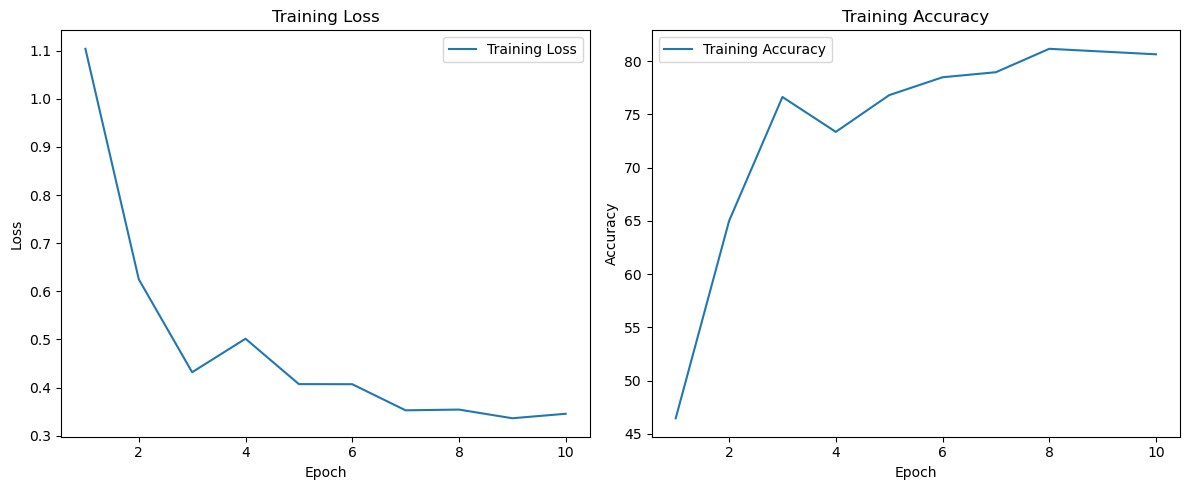

In [39]:
# Function to display sample predictions
def display_sample_predictions(model, test_loader, class_names, num_samples=5):
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Get num_samples random indices
            sample_indices = np.random.choice(len(images), num_samples, replace=False)
            
            plt.figure(figsize=(12, 8))
            for i, idx in enumerate(sample_indices):
                image = images[idx].permute(1, 2, 0)  # Convert back to (H, W, C) format
                label = class_names[labels[idx]]
                pred_label = class_names[predicted[idx]]
                
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(image)
                plt.title(f'True: {label}\nPredicted: {pred_label}')
                plt.axis('off')
            plt.show()
            break  # Display samples from the first batch only

# Plot training progress
plot_training_progress(train_losses, train_accuracies)




In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the new image
new_image_path = '/content/OIP.jpeg'
img = image.load_img(new_image_path, target_size=(input_shape[0], input_shape[1]))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the image, similar to how we did for training data

# Make the prediction
prediction = model.predict(x)
class_labels = train_generator.class_indices  # Get the mapping of class labels to their numeric values

# Convert prediction to human-readable class label
predicted_class_label = list(class_labels.keys())[np.argmax(prediction)]

# Display the image and predicted class label
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class_label}")
plt.axis('off')
plt.show()